<a href="https://colab.research.google.com/github/jbarrasa/goingmeta/blob/main/session24/python_notebooks/Ontology_Driven_RAG_patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install neo4j openai langchain tiktoken

In [ ]:
import os
from pprint import pprint
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['NEO4J_URL'] = "bolt://server_ip:7687"
os.environ['NEO4J_USR'] = "neo4j"
os.environ['NEO4J_PWD'] = ""

url = os.environ['NEO4J_URL']
username = os.environ['NEO4J_USR']
password = os.environ['NEO4J_PWD']

## Load the graph with the legislation document

In [ ]:
from langchain.graphs import Neo4jGraph

graph = Neo4jGraph(
    url=url,
    username=username,
    password=password
)

In [ ]:
graph.query("CREATE CONSTRAINT n10s_unique_uri IF NOT EXISTS FOR (r:Resource) REQUIRE r.uri IS UNIQUE")
graph.query("call n10s.graphconfig.init({handleVocabUris:'IGNORE'})")
graph.query("call n10s.rdf.import.fetch('https://raw.githubusercontent.com/jbarrasa/goingmeta/main/session23/data/db-as-rdf.ttl','Turtle');")
graph.query("match (r:Resource) remove r.uri, r:Resource ;")

### Check the graphs looks as expected

What our graph knows about 'unavailable deposits'

```
MATCH tree = (root)-[:CONTAINS*]->(d:Definition)-[:CONTAINS]->(c:Clause)
where d.term = "unavailable deposit" and c.definition is not null and not ()-[:CONTAINS]->(root)
return tree

```
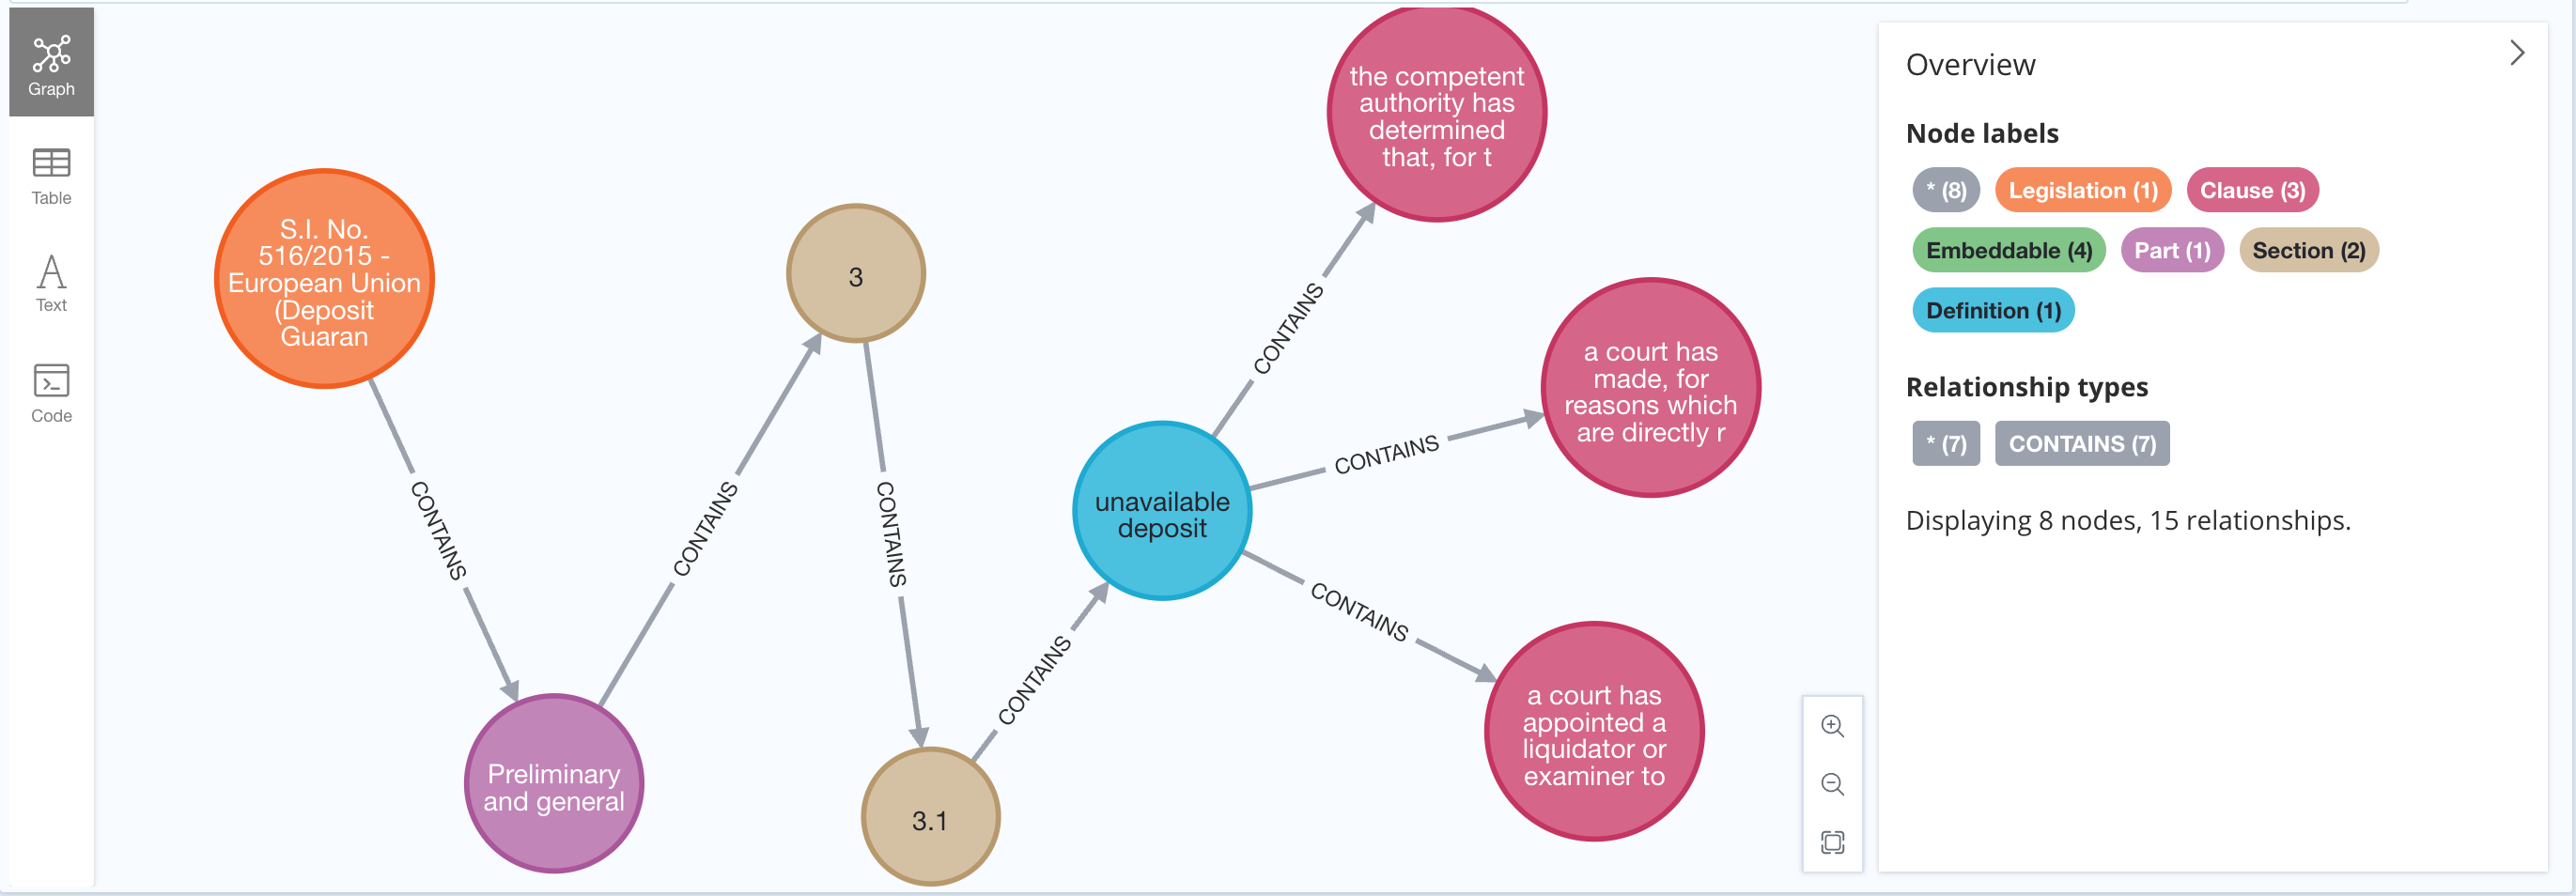

In [ ]:
from langchain.graphs import Neo4jGraph
from langchain.vectorstores.neo4j_vector import Neo4jVector
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI



vector_index = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    url=url,
    username=username,
    password=password,
    index_name='vector_index',
    node_label="Embeddable",
    text_node_properties=['definition', 'term', 'clause'],
    embedding_node_property='embedding',
)


In [ ]:
#question = "Qu'est-ce qu'un dépôt invalide et comment devient-il invalide?"
#question = "what definition mentions section 17 of the Building Societies Act ?"
question = "what is an unavailable deposit and how does it become unavailable?"

### Vector Search on Neo4j

In [ ]:
response = vector_index.similarity_search(question)
for r in response:
  print(r.page_content)

### RAG with Vector search

In [ ]:
vector_qa = RetrievalQA.from_chain_type(
    llm=ChatOpenAI(), chain_type="stuff", retriever=vector_index.as_retriever(k=1))

pprint(
    vector_qa.run(question)
)


## Advanced RAG patterns

### Further Detail (Specialising) Relationship and Inverse Contextualising

In [ ]:
def getRels(g, uri):
  get_specializing_rels = f"""
    match (:Resource {{ uri: "{uri}"}})<-[:SPO]-(r)
    return r.name as relname
    """
  return "|".join([ sr["relname"] for sr in g.query(get_specializing_rels) ])


def getDynamicContextQueryForPattern(g, pattern):

  default_query = """
    match (node)
    return reduce(s="", x in [x in keys(node) where node[x] is :: string] | s + ", " + x + ":" + node[x]) as text, score, {} as metadata
    """

  context_query = default_query

  if pattern == "FURTHER_DETAIL":

    rels = getRels(graph, "http://www.nsmntx.org/2024/01/rag#furtherDetailRelationship")

    if rels != "":
      context_query = f"""
      match (node)-[:{rels}]->(sc)
      with node.term + ' ' + node.definition as self,  reduce(s="", item in collect(reduce(s="", x in [x in keys(sc) where sc[x] is :: string] | s + " " +  sc[x])) | s + "
      " + item )  as ctxt, score, {{}} as metadata limit 1
      return self +  ctxt as text, score, metadata
      """

  elif pattern == "INVERSE_CONTEXT":

    rels = getRels(graph, "http://www.nsmntx.org/2024/01/rag#inverseContextualisingRelationship")

    if rels != "":
      context_query = f"""
      match (node)<-[:{rels}]-(parent) with parent, score
      match (parent)-[:{rels}]->(sc)
      with reduce(s="", x in [x in keys(parent) where parent[x] is :: string] | s + ", " + x + ":" + parent[x]) as self,  reduce(s="", item in collect(reduce(s="", x in [x in keys(sc) where sc[x] is :: string] | s +  sc[x])) | s + "
      " + item )  as ctxt, score, {{}} as metadata limit 1
      return self +  ctxt as text, score, metadata
      """

  return context_query


#### >> (LOAD THE ONTOLOGY BEFORE) Test how the Cypher is dynamically generated based on the ontology

In [ ]:
print(getDynamicContextQueryForPattern(graph,"FURTHER_DETAIL"))

### Create a contextualised handler on the vector index (with the chosen RAG pattern)

In [ ]:
contextualized_vectorstore = Neo4jVector.from_existing_index(
    OpenAIEmbeddings(),
    url=url,
    username=username,
    password=password,
    index_name="vector_index",
    retrieval_query=getDynamicContextQueryForPattern(graph,"INVERSE_CONTEXT"),    #INVERSE_CONTEXT   FURTHER_DETAIL
)


In [ ]:
response = contextualized_vectorstore.similarity_search(question)

for r in response:
  print(r.page_content)

### Create a QA Chain on the contextualised handler

In [ ]:
vector_plus_context_qa = RetrievalQA.from_chain_type(
    llm=ChatOpenAI(), chain_type="stuff", retriever=contextualized_vectorstore.as_retriever(k=1))

In [ ]:
pprint(
    vector_plus_context_qa.run(question)
    )
